# Forest Cover Prediction
## by: Avengers End Game
### authors: Naga Chandrasekaran, Scott Gatzemeier Aidan Jackson, and Andi Morey Peterson 

### Executive Summary

The goal of this project is to classify trees in four different wilderness areas of the Roosevelt National Forest in Northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.  Accurate results of a successful model will allow US Forest Service (USFS) to predict the predominant cover type trees to plant in reforestation efforts of the 800,000 acres in the Roosevelt National Forest.

![Picture Credit to: alchetron.com](https://i.ytimg.com/vi/Yi4ICw5L4h0/maxresdefault.jpg)

The data was collected by the USFS and the US Geological Survey and provided to Kaggle by Colorado State University.  Each entry of the dataset represents a 30x30 meter cell.  The project will attempt to predict one of seven cover types using features such as elevation, slope, soil type, wilderness areas, aspect, and distance measures.


#### Table of Contents:

1) Exploratory Data Analysis

2) Clean/Format Data and Feature Engineering

3) Initial Machine Learning Models

4) Hyperparameter Tuning

5) Evaluatation the Best Model

6) Interpret Model Results

7) Summary & Conclusions

### Exploratory Data Analysis

#### Read in Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

np.random.seed(0)

raw_data = pd.read_csv(r"data/covtype.csv") #https://www.kaggle.com/uciml/forest-cover-type-dataset
train_df = pd.read_csv(r"data/train.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data
test_df = pd.read_csv(r"data/test.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data


*Note on data sourcing*:  The data used for this project comes from Kaggle. The ["Raw" Data Set](https://www.kaggle.com/uciml/forest-cover-type-dataset) consists of both the train and test data sets and is labeled, however does not have ID's in which to identify each entry.  For the purposes of this project, the raw dataset will only be used for EDA but not used in model building. The train and test datasets [(found here)](https://www.kaggle.com/c/forest-cover-type-prediction/data) are used as such in all future models.

#### Shape and Features

In [11]:
#Print out Shape and features of the data
print('Data Dimensions for Raw Data:')
print('   Number of Records:', raw_data.shape[0])
print('   Number of Features:', raw_data.shape[1])
print('Data Dimensions for Train Data:')
print('   Number of Records:', train_df.shape[0])
print('   Number of Features:', train_df.shape[1])
print('Data Dimensions for Test Data:')
print('   Number of Records:', test_df.shape[0])
print('   Number of Features:', test_df.shape[1])
print('Feature Names:')
print(raw_data.columns)

Data Dimensions for Raw Data:
   Number of Records: 581012
   Number of Features: 55
Data Dimensions for Train Data:
   Number of Records: 15120
   Number of Features: 56
Data Dimensions for Test Data:
   Number of Records: 565892
   Number of Features: 55
Feature Names:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Ty

#### Class Information:

The seven cover types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

First, the distribution will tell if there is skewness in the predictions we are trying to replicate.

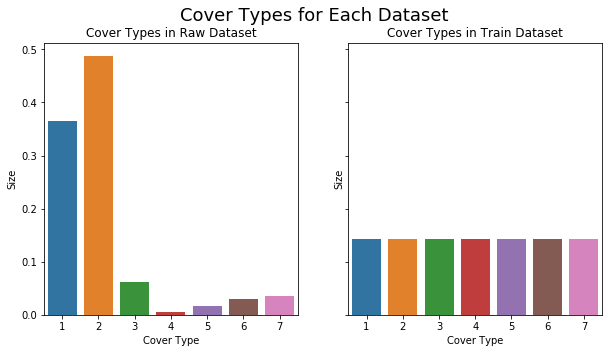

In [10]:
#Plot distribution of cover types
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

ax[0].set(ylabel='Percentage of Data')

class_dist=raw_data.groupby('Cover_Type').size()/raw_data.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[0],x=class_label.index,y='Size',data=class_label)
ax[0].set_title("Cover Types in Raw Dataset")
ax[0].set(xlabel='Cover Type')

class_dist=train_df.groupby('Cover_Type').size()/train_df.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[1],x=class_label.index,y='Size',data=class_label)
ax[1].set_title("Cover Types in Train Dataset")
ax[1].set(xlabel='Cover Type')

plt.suptitle('Cover Types for Each Dataset', fontsize=18)
plt.show()

The train data set that we will use for the model building is evenly distributed, but the raw dataset has skewness that we should be aware of and will contribute to overfitting of the train data.

#### Feature Information (cont):

The rest of the data that we can use as features for models are as follows:

- Elevation (continuous) - Elevation in meters
- Aspect (continuous) - Aspect in degrees azimuth
- Slope (continuous) - Slope in degrees
- Horizontal_Distance_To_Hydrology (continuous) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (continuous) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (continuous) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
    - Hillshade columns are the RGB color representation of the shadow at a particular time so the range is fixed between 0 and 255.
- Horizontal_Distance_To_Fire_Points (continuous) - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
    - Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Source:**: https://archive.ics.uci.edu/ml/datasets/covertype

First, let's take a look at our continuous data.

In the training and test dataset, the first 10 features of each observation (Elevation to Horizontal_Distance_To_Fire_Points) are continuous, with different ranges. The remaining 44 features are all binary. 4 of those 44 binary features correspond to Wilderness Area (i.e., there are 4 possible types), so any observation will have one 1 and three 0's in those columns. The last 40 features correspond to Soil Type (i.e., there are 40 possible types), so any observation will have one 1 and thirty-nine 0's in those columns.

#### Histograms

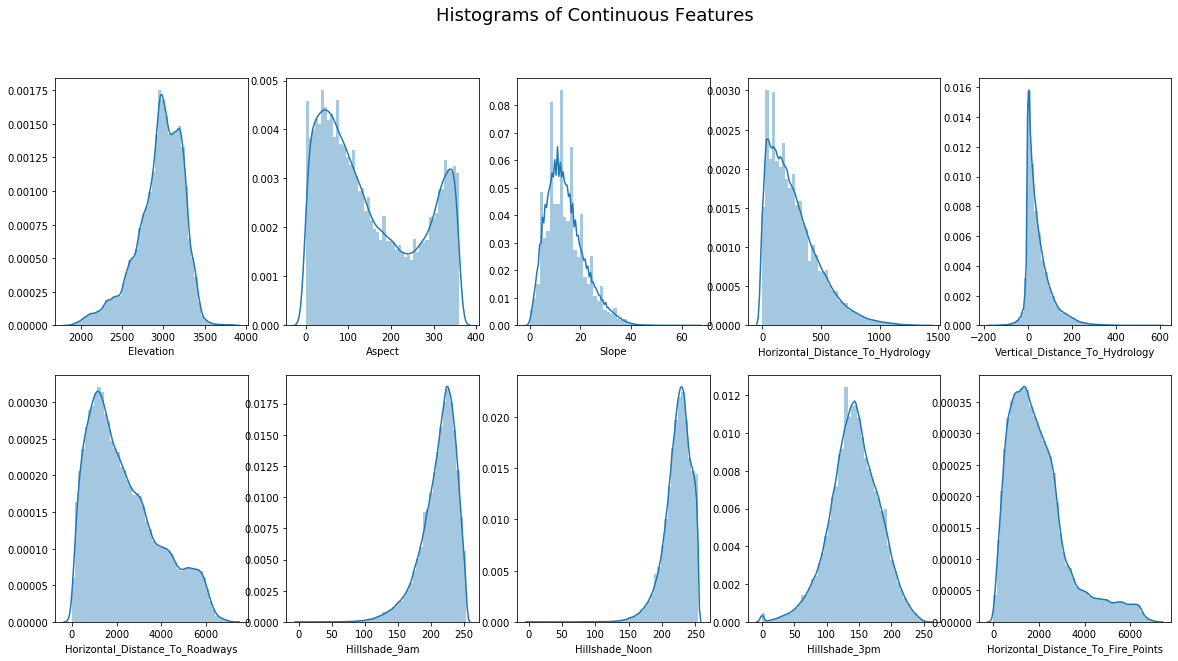

In [4]:
#plot the continuous data
fig, ax = plt.subplots(2, 5, figsize=(20,10))
continuous_data=raw_data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

for i, col in enumerate(continuous_data.columns):
    sns.distplot(ax=ax[int(i/5),i%5],a=continuous_data[col])
    
plt.suptitle('Histograms of Continuous Features', fontsize=18)
plt.show()

The histograms of each feature in the training data set indicates a non-normal distribution for most of the variables. Hillshade 3-m and slope show a near normal distribution. We noticed that the histogram of Hillshade_3pm contains several 0's, especially in the training set, which might make us think of missing values coded with 0, but according to the dataset description that feature can take this value, so we shall accept those values as valid. Wilderness area variable is a binary attribute with 0 or 1 for the values. Test data set distribution shown below is very similar to the training dataset distribution with the exception of Elevation and Slope attributes, which show a different distribution for test dataset.

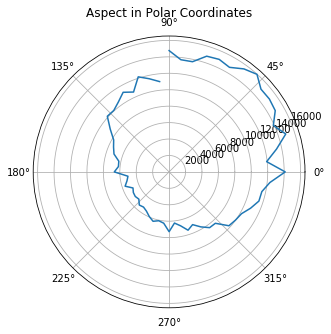

In [77]:
plt.figure(figsize=(15,5))
plt.polar((90-(np.histogram(raw_data["Aspect"], bins=60)[1][0:60]))*np.pi/180,
               np.histogram(raw_data["Aspect"], bins=60)[0][:60])
plt.title("Aspect in Polar Coordinates")
#plt.xticks([90*np.pi/180, 180*np.pi/180, 270*np.pi/180, 0*np,pi/180], ['N', 'W', 'S', 'E'])
#plt.xticks([0], ['E'])
plt.show()

#### Violin Plots of Key Continuous Features

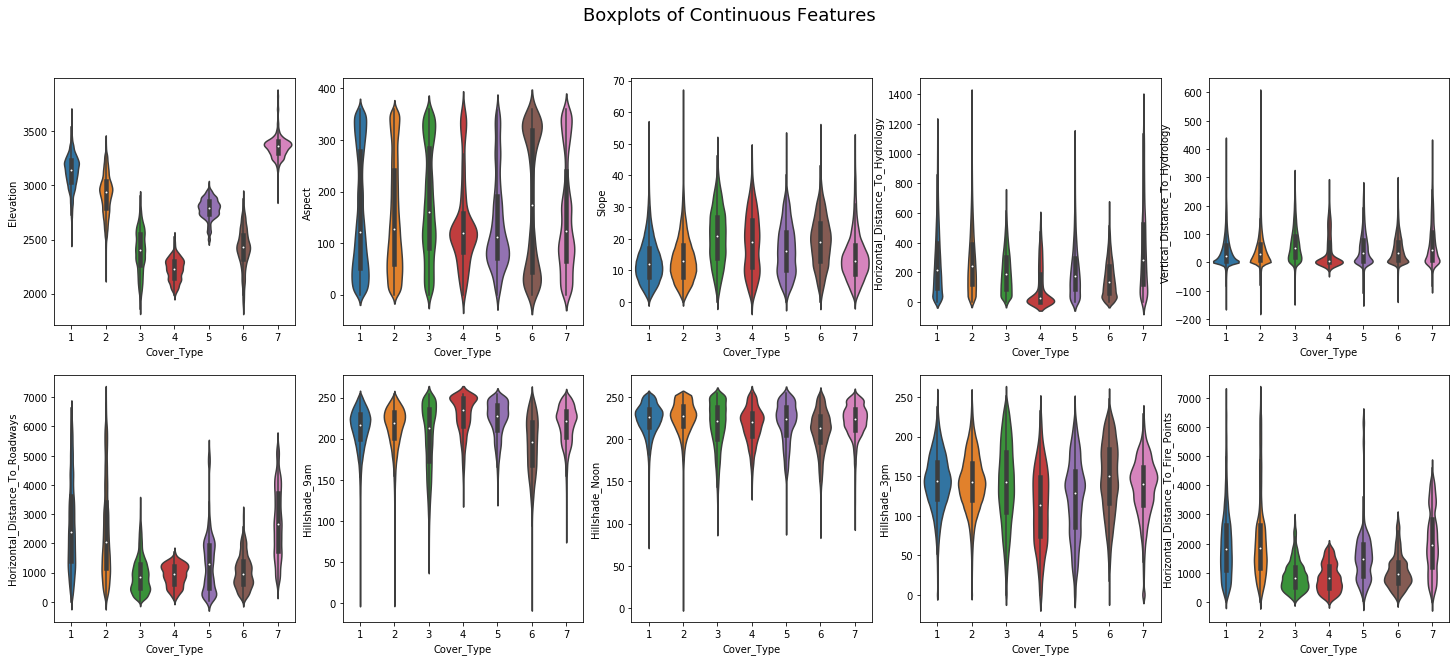

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
raw_data['Cover_Type']=raw_data['Cover_Type'].astype('category') #To convert target class into category
for i, col in enumerate(continuous_data.columns):
    #sns.boxplot(ax=ax[int(i/5),i%5], x=raw_data['Cover_Type'], y=col, data=raw_data)
    sns.violinplot(ax=ax[int(i/5),i%5], x=raw_data['Cover_Type'], y=col, data=raw_data)
    
plt.suptitle('Boxplots of Continuous Features', fontsize=18)
plt.show()

When we review different continuous variables as a function of the cover type, we can observe that elevation has the most dependence on cover type. We can see from the aboe box plots that cover type varies by elevation more while the box plots for aspect, slope, horizontal distance and other contiuous variables do not show any strong impact on cover type. While we observe some outiers, we do not see dependence of cover type on most continuous variables (except elevation).

#### Skewness

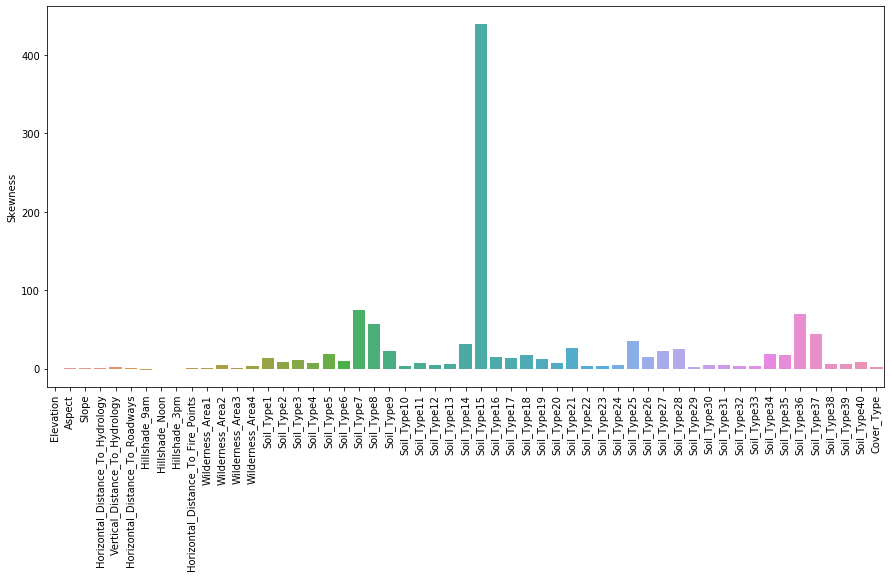

In [29]:
# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable 
# about its mean. Let us run skew to find the skewness in our data
skew=raw_data.skew()
skew_df=pd.DataFrame(skew,index=None,columns=['Skewness'])
plt.figure(figsize=(15,7))
sns.barplot(x=skew_df.index,y='Skewness',data=skew_df)
plt.xticks(rotation=90)
plt.show()


We can observe high skewness in few soil types in the data set. Based on this observation, we might have to perform some transformation to account for the skewness in the dataset.

#### Review Outliers in the data

In [24]:
### Comment by Andi - Should we do outliers in train or test or raw data here?

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

# loop through all columns to see if there are any outliers
for column in train_df.columns:
    if outlier_function(train_df, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(train_df, column)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points
There are 3597 outliers in Wilderness_Area1
There are 499 outliers in Wilderness_Area2
There are 355 outliers in Soil_Type1
There are 623 outliers in Soil_Type2
There are 962 outliers in Soil_Type3
There are 843 outliers in Soil_Type4
There are 165 outliers in Soil_Type5
There are 650 outliers in Soil_Type6
There are 1 outliers in Soil_Type8
There are 10 outliers in Soil_Type9
There are 2142 outliers in Soil_Type10
There are 406 outliers in Soil_Type11
There are 227 outliers in Soil_Type12
There are 476 outliers in Soil_Type13
There are 169 outliers in Soil_Type14
There are 114 outliers in Soil_Type16
There are 612 outliers in Soil_Type17
There are 60 outliers in Soil_Type18
There a

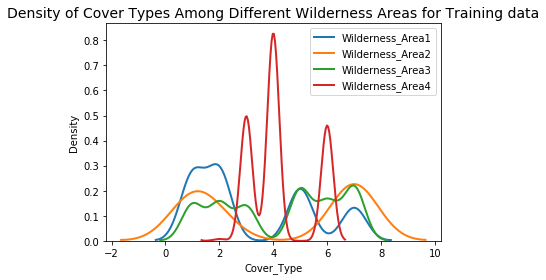

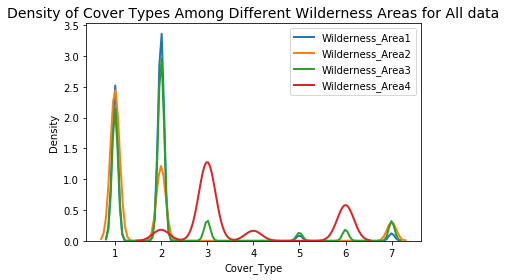

In [30]:
# Check if the Cover_Type shows non-uniform distribution among different Wilderness_Areas
# Create one column as Wilderness_Area_Type and represent it as categorical data

data = train_df.copy()
data['Wilderness_Area_Type'] = (data.iloc[:, 11:15] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(data['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize=(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = data[data['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas for Training data", size=14)
plt.show()


data = raw_data.copy()
data['Wilderness_Area_Type'] = (data.iloc[:, 10:14] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(data['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize=(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = data[data['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas for All data", size=14)
plt.show()


From the distribution plots on the train data, wilderness area 4 has a peak distribution with cover type 4 and secondary distributions around cover types 3 and 6. Wilderness area 1 has peak distribution around cover types 1 and 2 followed by 5 and 7. Wilderness area 2 has cover types 1 and 7 only. Wilderness area 3 has a spread of cover types.

In the raw dataset however, wilderness areas 1 and 2 have peak distributions for cover types 1 and 2 which is likely a function of the skewness of over types 1 and 2 in general as shown above.

#### Correlation Plots

*Comment by Andi - These correlation plots are awesome; however, when I replicate with the raw data or test data they look vastly different.  Should we plot both or continue with just train data?*

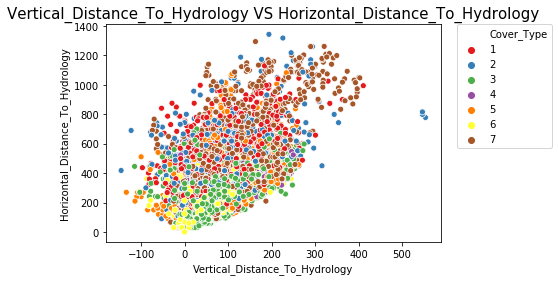

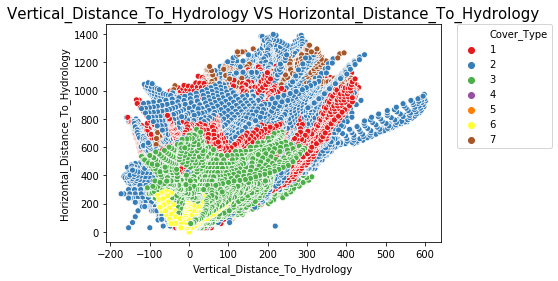

In [33]:
# Visualize some collinear features with Cover_Type

figsize = (20,20)

# plot the first subplot
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=train_df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Vertical_Distance_To_Hydrology VS Horizontal_Distance_To_Hydrology", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

figsize = (20,20)


All cover types show a linear relationship between vertical and horizontal distance to hydrology. The slopes of the cover types do not show any difference though the absolute position is different depending on the cover type. For a given vertical distance to hydrology, as the horizontal distance to hydrology increases the type of cover tends to change. Cover types 1, 2, and 7 are dominant at higher horizontal distance to hydrology while cover types 3 and 6 are dominant at lower horizontal distance to hydrology for a given vertical distance.

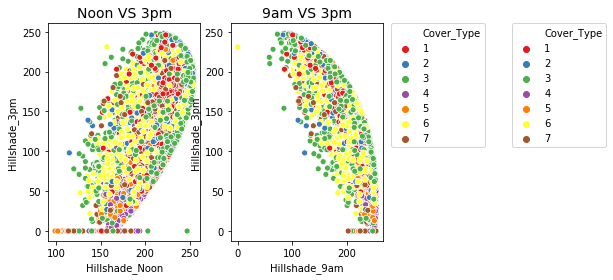

In [35]:
# Visualize hillshade correlations. We pick hillshade 3pm as the representative variable
figsize = (24,20)

# plot the first subplot - noon vs 3pm
plt.subplot(1,2,1)
sns.scatterplot(x="Hillshade_Noon", y="Hillshade_3pm", 
                hue="Cover_Type", data=train_df, 
                hue_norm=(0,8), palette="Set1")
plt.title("Noon VS 3pm", size=14)
plt.legend(bbox_to_anchor=(3.05, 1), loc=2, borderaxespad=0.)

# plot the second subplot - noon vs 9am
plt.subplot(1,2,2)
sns.scatterplot(x="Hillshade_9am", y="Hillshade_3pm", 
                hue="Cover_Type", data=train_df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("9am VS 3pm", size=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In the above plots, we are showing hillshade at 3 pm versus hillshade at noon and 9am. The axis values are proxy for illumination levels. Lower value represents no light and higher value is full brightness. In the noon time, hillshade has a positively increasing slope relationship with hillshade at 3pm. With increasing illumination on the hillshade at noon, the hillshade at 3pm also increases. For hillshade at 9m, there is a negative slope for hillshade at 3pm. When it is brightest at 9am, it shows lowest illumination intensity at the hillshade for 3pm. Based on observation, we can conclude that there are correlations between hillshade at different times and we can use one of the hillshade timing variable as a representation for hillshade as they are all correlated to each other.

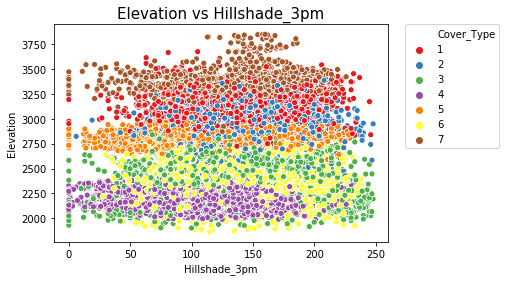

In [36]:
# Visualize some collinear features with Cover_Type

figsize = (20,20)

# plot the first subplot - Elevation vs Hillshade
sns.scatterplot(x="Hillshade_3pm", y="Elevation", 
                hue="Cover_Type", data=train_df,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation vs Hillshade_3pm", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We have seen from the earlier graphs that elevation has highest impact on cover type. Let us plot elevation vs hillshade at 3pm. Plot above shows the relationship between hillshade_3pm and elevation for different cover types. Cover types are more dependent on the elevation compared to specific hill shade at 3pm. In ascending order of elevation, following cover types can be found.

1. Cover type 4
2. Cover types 3 and 6
3. Cover type 5
4. Cover type 2
5. Cover type 1
6. Cover type 7

From the above we can consider that elevation has a significant impact on the cover type. We can also conclude that the distance to hydrology does have a secondary impact on the cover type.

In [73]:
# Count the total number of observations that are wilderness area types
# Wilderness = 100*X_train[:,10:14].sum(axis=0)/X_train[:,10:14].sum()

# # Count the total number of observations that are different soil types
# Soil = 100*X_train[:,14:54].sum(axis=0)/X_train[:,14:54].sum()

# # Plot the distribution of wilderness area
# plt.figure(figsize=(12, 4))
# plt.bar(np.arange(4), Wilderness, align="center")
# plt.title("Percentage of Wilderness Area cases in the training dataset")
# plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))
# plt.xlabel("Wilderness Area Type")
# plt.ylabel("Percentage in Training Dataset")

# # Plot the distribution of soil type
# plt.figure(figsize=(12, 4))
# plt.bar(np.arange(40), Soil, align="center")
# plt.title("Percentage of Soil Type cases in the training dataset")
# plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))
# plt.xlabel("Soil Type")
# plt.ylabel("Percentage in Training Dataset")

# plt.show()

*Comment by Andi* - For some reason this code isn't working.  Will work on later...

For the traiing dataset, we see over 40% of the data is represented by wilderness area type 3. This is followed by 30% and 25% representation by wilderness area type 4 and area type 1, respectively. In contrast, wilderness area type 2 has very low representation in training dataset.

There is a skewed distribution of soil type data in the training dataset. Soil type 10 has highest representation then there is a distribution of soil types represented in the data set. Some of the soil types have very low representation in the training dataset.

The test dataset distribution for wilderness area type and soil type looks very different from the training dataset. For the test data set, wilderness type 1 and 3 are represented heavily in the dataset with very low percentage of data (<10% each) for wilderness area types 1 and 2. Similarly, for soil type, there is a high representation for soil type 29 and significantly different distribution profile in the test data for soil types compared to training dataset. 